# Robot localization using particle filter
The robot has steering and velocity control inputs. It has sensors that measures distance to visible landmarks. Both the sensors and control mechanism have noise in them, and we need to track the robot's position.

In [1]:
import copy
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy import stats
from IPython.display import HTML
from matplotlib.patches import Circle

%matplotlib notebook

## Constuct particles randomly
Particles can be constructed by randomly sampling in the 2D space. 

In [2]:
def Uniform_Particles_Construction(width, height, N):

    # set the random seed so that we have reproducible experiments
    np.random.seed(500)

    particles = np.random.uniform([0,0], [width, height], size=(N, 2))
    return particles

## Rejection sampling
Since previous we get particles randomly among the total 2D spaces, it is possible that there are some particles located in the landmarks, thus we neet to delete these invalid particles.

In [3]:
def Rejection_Sampling(particles, centers, radius):
    """Given randomly sampled particles and centers of landmarks, perform rejection here
    
    Args:
        particles: the particles we get through random generation in 2D space
        centers: centers of landmarks
        radius: the radius of cicular landmarks 
    """
    particles_after_rejection = []
    for count_p, coord_p in enumerate(particles):
        dis = np.linalg.norm(coord_p-centers, axis=1, keepdims=True)
        if np.all(dis >= radius):
            particles_after_rejection.append(particles[count_p])
    return np.asarray(particles_after_rejection)

Now let's predefine some parameters and then run two examples to see the influence of number of evidence. What do you see in these two examples?

In [4]:
# test the rejection, nothing to do here.
[Width_Max, Height_Max]= [800, 600]

# Landmark center coordinates
# Version 0: five landmarks
Centers = np.array([ [336,175], [718,159], [510,43], [167, 333], [472, 437] ])
Radius=np.array([[12],[6],[7],[18],[9]])

if len(Centers) != len(Radius):
    raise ValueError("Centers and Radius must have the same size!")

Num_Particles = np.arange(1000, 10000, 1000)

for i in range(len(Num_Particles)):
    particles = Uniform_Particles_Construction(Width_Max, Height_Max, Num_Particles[i])
    rejection =  Rejection_Sampling(particles, Centers, Radius)
    print('Estimated acceptability for {} particles is {:.5f}'.format(Num_Particles[i], len(rejection[:,0])/len(particles[:,0])))

print('The true acceptability is {:.5f}'.format(1 - (np.pi * Radius * Radius).sum() / (Width_Max * Height_Max) ))

Estimated acceptability for 1000 particles is 0.99700
Estimated acceptability for 2000 particles is 0.99750
Estimated acceptability for 3000 particles is 0.99767
Estimated acceptability for 4000 particles is 0.99750
Estimated acceptability for 5000 particles is 0.99700
Estimated acceptability for 6000 particles is 0.99717
Estimated acceptability for 7000 particles is 0.99657
Estimated acceptability for 8000 particles is 0.99625
Estimated acceptability for 9000 particles is 0.99644
The true acceptability is 0.99585


## Motion model
Now we can move the remaining particles based on how you predict the real system is behaving with some noise in the motion model. Assume the time interval here is 1s.

In [5]:
def Predict(particles, v, std=1, dt=0.5):
    """Predict the motion of next state for each particles given current angles and velocities.
    
    Args:
        particles: the particles we get after rejection
        v： 2d array. Each sample with feature [angle, velocity]
        std: standard deviation of velociy, defaut 1
        dt: time interval, assume it to be 1 second here
    """
    N = len(particles)
    
    delta_dist = (v[1] * dt) + (np.random.randn(N) * std)
    particles[:, 0] += np.cos(v[0]) * delta_dist
    particles[:, 1] += np.sin(v[0]) * delta_dist

So how should we get the velocity of the robot?

In [6]:
def Compute_Velocity(Trajectory, delta_t=0.5):
    """Given the trajectory of robots, computer corresponding direction and velocity
    
    Args:
        Trajectory: np.ndarray, the coordinate of robot
        delta_t: int, default 0.5, depend on screen shot interval
    
    Returns:
        angle_and_velocity: np.ndarray in the form like [angel, velocity]
    
    """
    angle_and_velocity = []

    for i in range(len(Trajectory)-1):
        angle = np.arctan2(Trajectory[i+1, 1] - Trajectory[i, 1], Trajectory[i+1, 0] - Trajectory[i, 0])
        velocity = np.linalg.norm(Trajectory[i+1] - Trajectory[i]) / delta_t
        angle_and_velocity.append([angle, velocity])
        
    return angle_and_velocity

## Update the weights of each particle
Update the weighting of the particles based on the measurement. Each particle has a position and a weight which estimates how well it matches the measurement. Normalizing the weights so they sum to one turns them into a probability distribution. The particles those that are closest to the robot will generally have a higher weight than ones far from the robot. Particles that closely match the measurements are weighted higher than particles which don't match the measurements very well. So in this case, we can measure the probability using the distance to landmarks.

In [7]:
def Weights_Update(particles, weights, coord_rob, centers, radius, scale_fac, std):
    """Update the weights of particles based on their distance to the robot
    
    Args:
        coord_rob: the coordinate of robot
        centers: coordinate centers of landmarks
        radius: radius of each landmarks
        scale_fac: rescale the Gaussian distribution function to avoid underflow
    
    Return:
        weights: the weights of each particle after the update
    """
    # btw, maybe better to use the expectation to avoid underflow???
    weights.fill(1.) # initialization all weights to a same constant value
    dis_rob = np.linalg.norm(coord_rob - centers, axis=1, keepdims=True) - radius
    
    for count, center in enumerate(centers):
        # distance between the robot and each landmark
        distance = np.linalg.norm(particles-center, axis=1, keepdims=True) - radius[count]
        
        # set the distance as mean and R as standard deviation of norm distribution, then get the pdf as our new weights
        weights *= stats.norm.pdf(distance/scale_fac, dis_rob[count]/scale_fac, std)

    weights += 1.e-300   # avoid round-off to zero
    weights /= sum(weights)

# Resample Procedures
Discard highly improbable particle and replace them with copies of the more probable particles. Here you can refer to the procedure given as below:
<img src="img/Resample_Proedure.png" alt="Encoder" style="width: 400px;"/>

In [8]:
def systematic_resample(weights):
    """Discard highly improbable particle and replace them with copies of the more probable particles
    
    Args:
        weights: particle weights
        
    Returns:
        idx: the index of those remained weights
      
    """
    Num_Weights = len(weights)
    
    # make N subdivisions, choose positions with a consistent random offset
    delta_plus = (np.arange(Num_Weights) + np.random.random()) / Num_Weights
 
    idx = np.zeros(Num_Weights, 'i')
    cumulative_sum = np.cumsum(weights)
    
    i, j = 0, 0
    while i<Num_Weights and j<Num_Weights:
        if delta_plus[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
    return idx

The function above takes an array of weights and returns indexes to the particles that have been chosen for the resampling. We just need to write a function that performs the resampling from these indexes:

In [9]:
def resample_from_index(particles, weights, idx):
    
    particles[:] = particles[idx]
    weights[:] = weights[idx]
    weights /= np.sum(weights)

Now let's put the prediction positions of these particles together

In [10]:
# First get the input and compute the velocity
Input_Sequence = np.load('data/Trajectory_0.npy')
v = Compute_Velocity(Input_Sequence, 0.5)

# Then we get the particles
random_particles = Uniform_Particles_Construction(Width_Max, Height_Max, 50)
reject_particles = Rejection_Sampling(random_particles, Centers, Radius)
Origin_Weights = np.ones((len(reject_particles),1))

# Now we need to record the coordinates of moving particles
Prediction_Paticles = [reject_particles]

Pos = copy.copy(reject_particles)
Weights = copy.copy(Origin_Weights)

for i in range(len(Input_Sequence)-1):

    # The predicted position of particles
    Predict(Pos, v[i], 1, 0.5)
    Weights_Update(Pos, Weights, Input_Sequence[i], Centers, Radius, 50, 5)
    Index = systematic_resample(Weights)
    resample_from_index(Pos, Weights, Index)
    Prediction_Paticles.append(copy.copy(Pos))
    
Particle_Trajectory = np.asarray(Prediction_Paticles)

## Visulization
Now we visualize the moving of the robot to show how your particle filters works! What we need to achieve here is adding the moving of input sequence as well as particles onto that map.

In [11]:
def animate(i): 
    line.set_data(Input_Sequence[:i+1,:].T) # update the data 
    scat.set_offsets(Particle_Trajectory[i])
    return line, scat,

# Init only required for blitting to give a clean slate. 
def init(): 
    line.set_data(Input_Sequence[1,0], Input_Sequence[1,1])
    scat.set_offsets(Particle_Trajectory[0,:,:])
    return line, scat, 

<IPython.core.display.Javascript object>


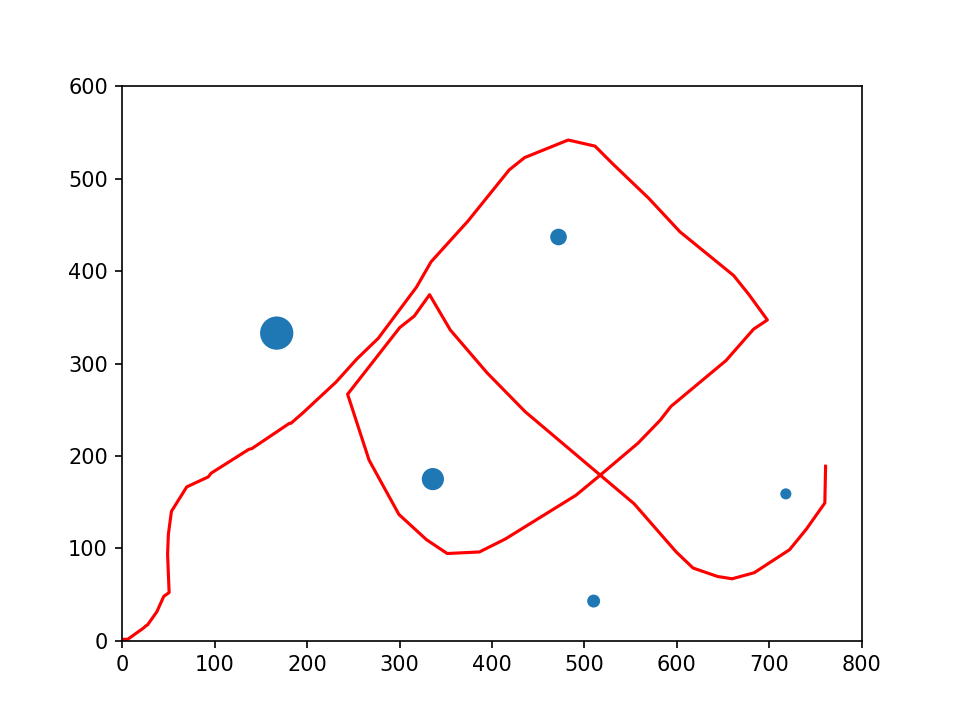

In [12]:
img = plt.imread('img/Canvas.png')
fig,ax = plt.subplots(1)

# Now, loop through coord arrays, and create a circle at center
for count, value in enumerate(Centers):
    circ = Circle(value,Radius[count])
    ax.add_patch(circ)

# Create a figure. Equal aspect so circles look circular
ax.set_aspect('equal')
ax.imshow(img)

# Initialization
line, = ax.plot(Input_Sequence[1,0], Input_Sequence[1,1], 'r')
scat = ax.scatter(Particle_Trajectory[0,:,0], Particle_Trajectory[0,:,1],s=3, c='g')

plt.xlim(0, Width_Max) 
plt.ylim(0, Height_Max) 

# ani = animation.FuncAnimation(fig, animate, np.arange(1, len(Input_Sequence)-1), init_func=init, interval=500, blit=True) 
ani = animation.FuncAnimation(fig, animate, np.arange(1,len(Input_Sequence)-1), init_func=init, interval=150, blit=True) 
_ = HTML(ani.to_html5_video())

In [13]:
Writer = animation.PillowWriter(fps=10)
ani.save("result/Random_Particle_Filter_0.gif", writer=Writer)

We see that the robot starts at zero point, but the particles sampled randomly in the 2D spaces rarely go close to the zero, hence cause the bias which exists all over the trajectory. So instead, let's try with the Gaussian sample menthod.

In [14]:
def Gaussian_Particles_Construction(N, sigma):
    particles = sigma * np.random.randn(N, 2)
    return particles

In [15]:
gaussian_particles = Gaussian_Particles_Construction(50, 5)
reject_particles = Rejection_Sampling(gaussian_particles, Centers, Radius)
Origin_Weights = np.ones((len(reject_particles),1))

# Now we need to record the coordinates of moving particles
Prediction_Paticles = [reject_particles]

Pos = copy.copy(reject_particles)
Weights = copy.copy(Origin_Weights)

for i in range(len(Input_Sequence)-1):

    Predict(Pos, v[i], 1, 0.5)
    Weights_Update(Pos, Weights, Input_Sequence[i], Centers, Radius, 50, 5)
    Index = systematic_resample(Weights)
    resample_from_index(Pos, Weights, Index)
    Prediction_Paticles.append(copy.copy(Pos))
    
Particle_Trajectory = np.asarray(Prediction_Paticles)

In [16]:
img = plt.imread('img/Canvas.png')
fig,ax = plt.subplots(1)

# Now, loop through coord arrays, and create a circle at center
for count, value in enumerate(Centers):
    circ = Circle(value,Radius[count])
    ax.add_patch(circ)

# Create a figure. Equal aspect so circles look circular
ax.set_aspect('equal')
ax.imshow(img)

# Initialization
line, = ax.plot(Input_Sequence[1,0], Input_Sequence[1,1], 'r')
scat = ax.scatter(Particle_Trajectory[0,:,0], Particle_Trajectory[0,:,1],s=3, c='g')

plt.xlim(0, Width_Max) 
plt.ylim(0, Height_Max) 

# ani = animation.FuncAnimation(fig, animate, np.arange(1, len(Input_Sequence)-1), init_func=init, interval=500, blit=True) 
ani = animation.FuncAnimation(fig, animate, np.arange(1,len(Input_Sequence)-1), init_func=init, interval=150, blit=True) 
_ = HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>

In [17]:
ani.save("result/Gaussian_Particle_Filter_0.gif", writer=Writer)